# DCEGM Upper Envelope
## ["The endogenous grid method for discrete-continuous dynamic choice models with (or without) taste shocks"](https://onlinelibrary.wiley.com/doi/abs/10.3982/QE643)

<p style="text-align: center;"><small><small><small>For the following badges: GitHub does not allow click-through redirects; right-click to get the link, then paste into navigation bar</small></small></small></p>

[![Open in Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/econ-ark/DemARK/master?filepath=notebooks%2FDCEGM-Upper-Envelope.ipynb)

[![Open in CoLab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/econ-ark/DemARK/blob/master/notebooks/DCEGM-Upper-Envelope.ipynb)



This notebook provides a simple introduction to the upper envelope calculation in the "DCEGM" algorithm <cite data-cite="6202365/4F64GG8F"></cite>. It takes the EGM method proposed in <cite data-cite="6202365/HQ6H9JEI"></cite>, and extends it to the mixed choice (discrete and continuous) case. It handles various constraints. It works on a 1-dimensional problems.

The main challenge in the types of models considered in DCEGM is, that the first order conditions to the Bellman equations are no longer sufficient to find an optimum.  Though, they are still necessary in a broad class of models. This means that our EGM step will give us (resource, consumption) pairs that do fulfill the FOCs, but that are sub-optimal (there's another consumption choices for the same initial resources that gives a higher value).

Take a consumption model formulated as:
$$
\max_{\{c_t\}^T_{t=1}} \sum^T_{t=1}\beta^t\cdot u(c_t)
$$
given some initial condition on $x$ and some laws of motion for the states, though explicit references to states are omitted. Then, if we're in a class of models described in EGM
, we can show that
$$
c_t = {u_{c}}^{-1}[E_t(u_c(c_{t+1}))]
$$
uniquely determines an optimal consumption today given the expected marginal utility of consuming  tomorrow. However, if there is a another choice in the choice set, and that choice is discrete, we get
$$
\max_{\{c_t, d_t\}^T_{t=1}} \sum^T_{t=1}\beta^t\cdot u(c_t, d_t)
$$
again given initial conditions and the laws of motion. Then, we can show that
$$
c_t = {u_{c}}^{-1}[E_t(u_c(c_{t+1}))]
$$
will produce solutions that are necessary but not sufficient. Note, that there is no explicit mentioning of the discrete choices in the expectation, but they obviously vary over the realized states in general. For the optimal consumption, it doesn't matter what the choice is exactly, only what expected marginal utility is tomorrow. The algorithm presented in [1] is designed to take advantage of models with this structure.

To visualize the problem, consider the following pictures that show the output of an EGM step from the model in the REMARK [linkhere].

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# here for now, should be
# from HARK import discontools or whatever name is chosen
from HARK.interpolation import LinearInterp
from HARK.dcegm import calcSegments, calcMultilineEnvelope, calcPrimKink

In [3]:
m_common = np.linspace(0,1.0,100)
m_egm = np.array([0.0, 0.04, 0.25, 0.15, 0.1, 0.3, 0.6,0.5, 0.35, 0.6, 0.75,0.85])
c_egm = np.array([0.0, 0.03, 0.1, 0.07, 0.05, 0.36, 0.4, 0.6, 0.8, 0.9,0.9,0.9])
vt_egm = np.array( [0.0, 0.05, 0.1,0.04, 0.02,0.2, 0.7, 0.5, 0.2, 0.9, 1.0, 1.2])

Text(0, 0.5, 'transformed values')

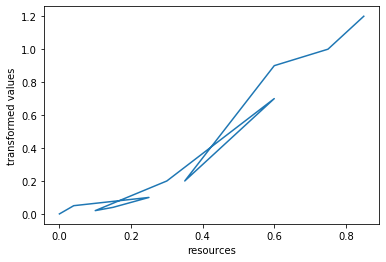

In [4]:
plt.plot(m_egm, vt_egm)
plt.xlabel("resources")
plt.ylabel("transformed values")

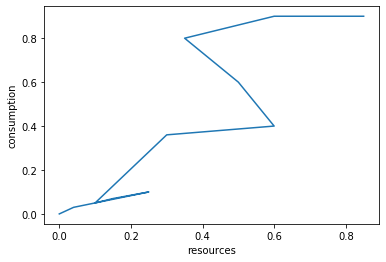

In [5]:
plt.plot(m_egm, c_egm)
plt.xlabel("resources")
plt.ylabel("consumption")
plt.show()

The point of DCEGM is to realize, that the segments on the `(m, vt)` curve that are decreasing, cannot be optimal. This leaves us with a set of increasing line segments, as seen below (`dcegmSegments` is the function in HARK that calculates the breaks where the curve goes from increasing to decreasing).

In [6]:
rise, fall = calcSegments(m_egm, vt_egm)

In `rise` we have all the starting indices for the segments that are "good", that is `(m, vt)` draws an increasing curve.

In [7]:
rise

array([0, 4, 8])

We see that `rise` has its first index at `0`, then again at `4`, and lastly at `8`. Let's look at `fall`.

In [8]:
fall

array([ 2,  6, 11])

We see that the last segment is increasing (as the last element of `rise` is larger than the last element of `fall`), and we see that `len(fall)` is one larger than number of problematic segments in the plot. The index of the last point in `m_egm`/`c_egm`/`vt_egm` is added for convenience when we do the upper envelope step (and is also convenient below for drawing the segments!).

We can use `fall` and `rise` to draw only the relevant segments that we will use to construct an upper envelope.

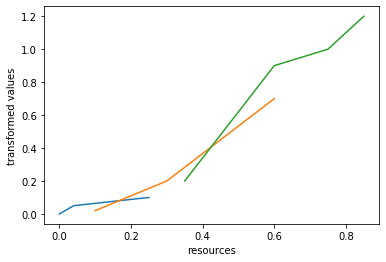

In [9]:
for j in range(len(fall)):
    idx = range(rise[j],fall[j]+1)
    plt.plot(m_egm[idx], vt_egm[idx])
plt.xlabel("resources")
plt.ylabel("transformed values")
plt.show()

Let us now use the `calcMultilineEnvelope` function to do the full DCEGM step: find segments and calculate upper envelope in one sweep.

In [10]:
m_upper, c_upper, v_upper = calcMultilineEnvelope(m_egm, c_egm, vt_egm, m_common)

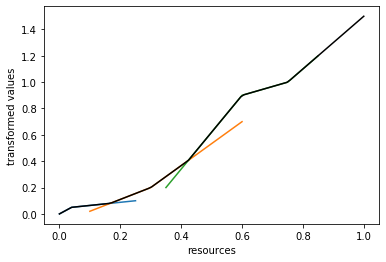

In [11]:
for j in range(len(fall)):
    idx = range(rise[j],fall[j]+1)
    plt.plot(m_egm[idx], vt_egm[idx])
plt.plot(m_upper, v_upper, 'k')
plt.xlabel("resources")
plt.ylabel("transformed values")
plt.show()

And there we have it! These functions are the building blocks for univariate discrete choice modeling in HARK, so hopefully this little demo helped better understand what goes on under the hood, or it was a help if you're extending some existing class with a discrete choice.

# An example: writing a will

We now present a basic example to illustrate the use of the previous tools in solving dynamic optimization problems with discrete and continuous decisions.

The model represents an agent that lives for three periods and decides how much of his resources to consume in each of them. On the second period, he must additionally decide whether to hire a lawyer to write a will. Having a will has the upside of allowing the agent to leave a bequest in his third and last period of life, which gives him utility, but has the downside that the lawyer will charge a fraction of his period 3 resources.

On each period, the agent receives a deterministic amount of resources $w$. The problem, therefore, is fully deterministic.

I now present the model formally, solving it backwards.

But first, some setup and calibration:

In [12]:
# Import tools for linear interpolation and finding optimal
# discrete choices.
from HARK.interpolation import calcLogSumChoiceProbs

# Import CRRA utility (and related) functions from HARK 
from HARK.utilities import CRRAutility, CRRAutilityP, CRRAutilityP_inv

# Solution method parameters
aGrid = np.linspace(0,8,400) # Savings grid for EGM.

# Model parameters

# Parameters that need to be fixed
# Relative risk aversion. This is fixed at 2 in order to mantain
# the analytical solution that we use, from Carroll (2000)
CRRA   = 2 

# Parameters that can be changed.
w          = 1    # Deterministic wage per period.
willCstFac = 0.35 # Fraction of resources charged by lawyer for writing a will.
DiscFac    = 0.98 # Time-discount factor.

# Define utility (and related) functions
u     = lambda x: CRRAutility(x,CRRA)
uP    = lambda x: CRRAutilityP(x, CRRA)
uPinv = lambda x: CRRAutilityP_inv(x, CRRA)

# Create a grid for market resources
mGrid       = (aGrid-aGrid[0])*1.5
mGridPlots  = np.linspace(w,10*w,100)
mGridPlotsC = np.insert(mGridPlots,0,0)

# Transformations for value funtion interpolation
vTransf   = lambda x: np.exp(x)
vUntransf = lambda x: np.log(x)

# The third (last) period of life

In the last period of life, the agent's problem is determined by his total amount of resources $m_3$ and a state variable $W$ that indicates whether he wrote a will ($W=1$) or not ($W=0$).

### The agent without a will

An agent who does not have a will simply consumes all of his available resources. Therefore, his value and consumption functions will be:

\begin{equation}
V_3(m_3,W=0) = u(m_3)
\end{equation}

\begin{equation}
c_3(m_3, W=0) = m_3
\end{equation}

Where $u(\cdot)$ gives the utility from consumption. We assume a CRRA specification $u(c) = \frac{c^{1-\rho}}{1-\rho}$.

### The agent with a will

An agent who wrote a will decides how to allocate his available resources $m_3$ between his consumption and a bequest. We assume an additive specification for the utility of a given consumption-bequest combination that follows a particular case in [Carroll (2000)](http://www.econ2.jhu.edu/people/ccarroll/Why.pdf). The component of utility from leaving a bequest $x$ is assumed to be $\ln (x+1)$. Therefore, the agent's value function is

\begin{equation}
V_3(m_3, W=1) = \max_{0\leq c_3 \leq m_3} u(c_3) + \ln(m_3 - c_3 + 1)
\end{equation}

For ease of exposition we consider the case $\rho = 2$, where [Carroll (2000)](http://www.econ2.jhu.edu/people/ccarroll/Why.pdf) shows that the optimal consumption level is given by

\begin{equation}
c_3(m_3, W=1) = \min \left[m_3, \frac{-1 + \sqrt{1 + 4(m_3+1)}}{2} \right].
\end{equation}

The consumption function shows that $m_3=1$ is the level of resources at which an important change of behavior occurs: agents leave bequests only for $m_3 > 1$. Since an important change of behavior happens at this point, we call it a 'kink-point' and add it to our grids.

c:\github\hark\HARK\utilities.py:141: RuntimeWarning: divide by zero encountered in reciprocal
  return( c**(1.0 - gam) / (1.0 - gam) )


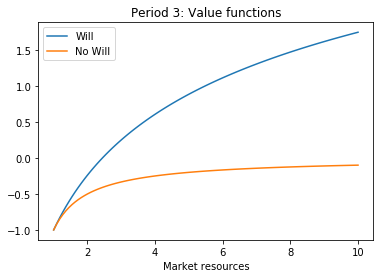

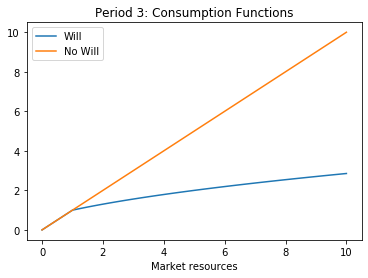

In [13]:
# Agent without a will
mGrid3_no = mGrid
cGrid3_no = mGrid
vGrid3_no = u(cGrid3_no)

# Create functions
c3_no  = LinearInterp(mGrid3_no, cGrid3_no) # (0,0) is already here.
vT3_no = LinearInterp(mGrid3_no, vTransf(vGrid3_no), lower_extrap = True)
v3_no  = lambda x: vUntransf(vT3_no(x))

# Agent with a will

# Define an auxiliary function with the analytical consumption expression
c3will = lambda m: np.minimum(m, -0.5 + 0.5*np.sqrt(1+4*(m+1)))

# Find the kink point
mKink = 1.0
indBelw = mGrid < mKink
indAbve = mGrid > mKink

mGrid3_wi = np.concatenate([mGrid[indBelw],
                            np.array([mKink]),
                            mGrid[indAbve]])

cGrid3_wi = c3will(mGrid3_wi)

cAbve = c3will(mGrid[indAbve])
beqAbve = mGrid[indAbve] - c3will(mGrid[indAbve])
vGrid3_wi = np.concatenate([u(mGrid[indBelw]),
                             u(np.array([mKink])),
                             u(cAbve) + np.log(1+beqAbve)])

# Create functions
c3_wi  = LinearInterp(mGrid3_wi, cGrid3_wi) # (0,0) is already here
vT3_wi = LinearInterp(mGrid3_wi, vTransf(vGrid3_wi), lower_extrap = True)
v3_wi  = lambda x: vUntransf(vT3_wi(x))

plt.figure()

plt.plot(mGridPlots, v3_wi(mGridPlots), label = 'Will')
plt.plot(mGridPlots, v3_no(mGridPlots), label = 'No Will')
plt.title('Period 3: Value functions')
plt.xlabel('Market resources')
plt.legend()
plt.show()

plt.plot(mGridPlotsC, c3_wi(mGridPlotsC), label = 'Will')
plt.plot(mGridPlotsC, c3_no(mGridPlotsC), label = 'No Will')
plt.title('Period 3: Consumption Functions')
plt.xlabel('Market resources')
plt.legend()
plt.show()

# The second period

On the second period, the agent takes his resources as given (the only state variable) and makes two decisions:
- Whether to write a will or not.
- What fraction of his resources to consume.

These decisions can be seen as happening sequentially: the agent first decides whether to write a will or not, and then consumes optimally in accordance with his previous decision. Since we solve the model backwards in time, we first explore the consumption decision, conditional on the choice of writing a will or not.

## An agent who decides not to write a will

After deciding not to write a will, an agent solves the optimization problem expressed in the following conditional value function

\begin{equation}
\begin{split}
\nu (m_2|w=0) &= \max_{0\leq c \leq m_2} u(c) + \beta V_3(m_3,W=0)\\
s.t.&\\
m_3 &= m_2 - c + w
\end{split} 
\end{equation}

We can approximate a solution to this problem through the method of endogenous gridpoints. This yields approximations to $\nu(\cdot|w=0)$ and $c_2(\cdot|w=0)$

In [14]:
# Second period, not writing a will

# Compute market resources at 3 with and without a will
mGrid3_cond_nowi = aGrid + w
# Compute marginal value of assets in period 3 for each ammount of savings in 2
vPGrid3_no = uP(c3_no(mGrid3_cond_nowi))
# Get consumption through EGM inversion of the euler equation
cGrid2_cond_no = uPinv(DiscFac*vPGrid3_no)

# Get beginning-of-period market resources
mGrid2_cond_no = aGrid + cGrid2_cond_no

# Compute value function
vGrid2_cond_no = u(cGrid2_cond_no) + DiscFac*v3_no(mGrid3_cond_nowi)

# Create interpolating value and consumption functions
vT2_cond_no = LinearInterp(mGrid2_cond_no, vTransf(vGrid2_cond_no), lower_extrap = True)
v2_cond_no  = lambda x: vUntransf(vT2_cond_no(x))
c2_cond_no  = LinearInterp(np.insert(mGrid2_cond_no,0,0), np.insert(cGrid2_cond_no,0,0))

## An agent who decides to write a will

An agent who decides to write a will also solves for his consumption dinamically. We assume that the lawyer that helps the agent write his will takes some fraction $\tau$ of his total resources in period 3. Therefore, the evolution of resources is given by $m_3 = (1-\tau)(m_2 - c_2 + w)$. The conditional value function of the agent is therefore:

\begin{equation}
\begin{split}
\nu (m_2|w=1) &= \max_{0\leq c \leq m_2} u(c) + \beta V_3(m_3,W=1)\\
s.t.&\\
m_3 &= (1-\tau)(m_2 - c + w)
\end{split} 
\end{equation}

We also approximate a solution to this problem using the EGM. This yields approximations to $\nu(\cdot|w=1)$ and $c_2(\cdot|w=1)$.

In [15]:
# Second period, writing a will

# Compute market resources at 3 with and without a will
mGrid3_cond_will = (1-willCstFac)*(aGrid + w)
# Compute marginal value of assets in period 3 for each ammount of savings in 2
vPGrid3_wi = uP(c3_wi(mGrid3_cond_will))
# Get consumption through EGM inversion of the euler equation
cGrid2_cond_wi = uPinv(DiscFac*(1-willCstFac)*vPGrid3_wi)
# Get beginning-of-period market resources
mGrid2_cond_wi = aGrid + cGrid2_cond_wi

# Compute value function
vGrid2_cond_wi = u(cGrid2_cond_wi) + DiscFac*v3_wi(mGrid3_cond_will)

# Create interpolating value and consumption functions
vT2_cond_wi = LinearInterp(mGrid2_cond_wi, vTransf(vGrid2_cond_wi), lower_extrap = True)
v2_cond_wi  = lambda x: vUntransf(vT2_cond_wi(x))
c2_cond_wi  = LinearInterp(np.insert(mGrid2_cond_wi,0,0), np.insert(cGrid2_cond_wi,0,0))

## The decision whether to write a will or not

With the conditional value functions at hand, we can now express and solve the decision of whether to write a will or not, and obtain the unconditional value and consumption functions.

\begin{equation}
V_2(m_2) = \max \{ \nu (m_2|w=0), \nu (m_2|w=1) \}
\end{equation}

\begin{equation}
w^*(m_2) = \arg \max_{w \in \{0,1\}} \{ \nu (m_2|w=w) \}
\end{equation}

\begin{equation}
c_2(m_2) = c_2(m_2|w=w^*(m_2))
\end{equation}

We now construct these objects.

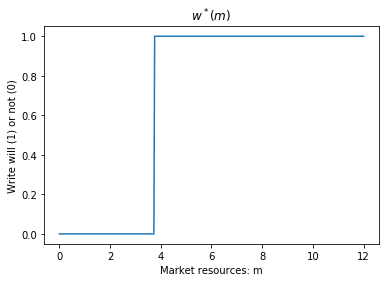

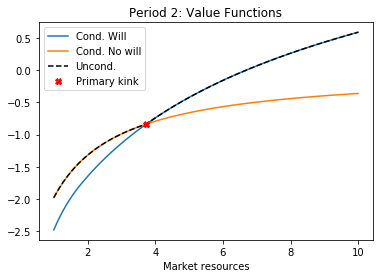

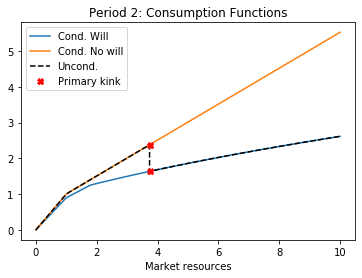

In [16]:
# We use HARK's 'calcLogSumchoiceProbs' to compute the optimal
# will decision over our grid of market resources.
# The function also returns the unconditional value function
# Use transformed values since -given sigma=0- magnitudes are unimportant. This
# avoids NaNs at m \approx 0.
vTGrid2, willChoice2 = calcLogSumChoiceProbs(np.stack((vT2_cond_wi(mGrid),
                                                     vT2_cond_no(mGrid))),
                                             sigma = 0)

# Plot the optimal decision rule
plt.plot(mGrid, willChoice2[0])
plt.title('$w^*(m)$')
plt.ylabel('Write will (1) or not (0)')
plt.xlabel('Market resources: m')
plt.show()

# With the decision rule we can get the unconditional consumption grid
cGrid2 = (willChoice2*np.stack((c2_cond_wi(mGrid),c2_cond_no(mGrid)))).sum(axis=0)

# Now find the primary kink point (the point at which the optimal discrete
# decision changes)
pKink, segments = calcPrimKink(mGrid, np.stack((vT2_cond_wi(mGrid),
                                                vT2_cond_no(mGrid))),
                               willChoice2)

m_kink = np.array([x[0] for x in pKink])
v_kink = np.array([x[1] for x in pKink])

# Insert the kink point into the value function grid and create the function.
idx = np.searchsorted(mGrid, m_kink)
mGrid_k = np.insert(mGrid, idx, m_kink)
vTGrid2_k = np.insert(vTGrid2, idx, v_kink)

vT2 = LinearInterp(mGrid_k, vTGrid2_k, lower_extrap = True)
v2  = lambda x: vUntransf(vT2(x))

# Plot the conditional and unconditional value functions
mGridPlots_k = np.concatenate([mGridPlots,m_kink])
mGridPlots_k.sort()
plt.plot(mGridPlots_k, v2_cond_wi(mGridPlots_k), label = 'Cond. Will')
plt.plot(mGridPlots_k, v2_cond_no(mGridPlots_k), label = 'Cond. No will')
plt.plot(mGridPlots_k, v2(mGridPlots_k), 'k--',label = 'Uncond.')
plt.plot(m_kink, v2(m_kink), 'rX', label = 'Primary kink')
plt.title('Period 2: Value Functions')
plt.xlabel('Market resources')
plt.legend()
plt.show()

# Add kink points to consumption function. Make the discontinuity evident
add_c = []
add_m = []
cond_cfuncs = [c2_cond_wi, c2_cond_no]
for i in range(len(m_kink)):
    ml = m_kink[i]
    mr = np.nextafter(ml, np.inf)
    # Point to the left of the discontinuity
    add_m.append(ml)
    add_c.append(cond_cfuncs[segments[i,0]](ml))
    # Point to the right of the discontinuitiy
    add_m.append(mr)
    add_c.append(cond_cfuncs[segments[i,1]](mr))
   
# Add to grids    
idx = np.searchsorted(mGrid, add_m)
mGrid_k = np.insert(mGrid, idx, add_m)
cGrid2_k = np.insert(cGrid2, idx, add_c)

# Create function
c2  = LinearInterp(mGrid_k, cGrid2_k)

# Plot the conditional and unconditional consumption
# functions
mGridPlotsC_k = np.concatenate([mGridPlotsC,add_m])
mGridPlotsC_k.sort()
plt.plot(mGridPlotsC_k, c2_cond_wi(mGridPlotsC_k), label = 'Cond. Will')
plt.plot(mGridPlotsC_k, c2_cond_no(mGridPlotsC_k), label = 'Cond. No will')
plt.plot(mGridPlotsC_k, c2(mGridPlotsC_k), 'k--',label = 'Uncond.')
plt.plot(add_m, c2(add_m), 'rX', label = 'Primary kink')
plt.title('Period 2: Consumption Functions')
plt.xlabel('Market resources')
plt.legend()
plt.show()

# The first period

In the first period, the agent simply observes his market resources and decides what fraction of them to consume. His problem is represented by the following value function

\begin{equation}
\begin{split}
V (m_1) &= \max_{0\leq c \leq m_1} u(c) + \beta V_2(m_2)\\
s.t.&\\
m_2 &= m_1 - c + w.
\end{split} 
\end{equation}

Although this looks like a simple problem, there are complications introduced by the kink in $V_2(\cdot)$, which is clearly visible in the plot from the previous block. Particularly, note that $V_2'(\cdot)$ and $c_2(\cdot)$ are not monotonic: there are now multiple points $m$ for which the slope of $V_2(m)$ is equal. Thus, the Euler equation becomes a necessary but not sufficient condition for optimality and the traditional EGM inversion step can generate non-monotonic endogenous $m$ gridpoints.

We now illustrate this phenomenon.

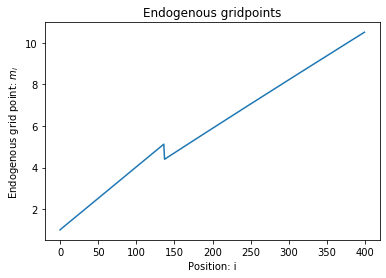

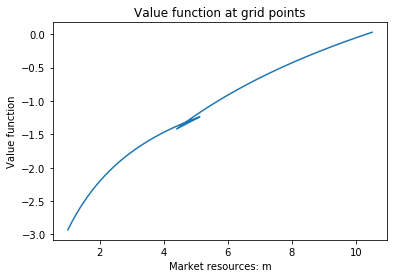

In [17]:
# EGM step

# Period 2 resources implied by the exogenous savings grid
mGrid2 = aGrid + w
# Envelope condition
vPGrid2 = uP(c2(mGrid2))
# Inversion of the euler equation
cGrid1 = uPinv(DiscFac*vPGrid2)
# Endogenous gridpoints
mGrid1 = aGrid + cGrid1
vGrid1 = u(cGrid1) + DiscFac*v2(mGrid2)

plt.plot(mGrid1)
plt.title('Endogenous gridpoints')
plt.xlabel('Position: i')
plt.ylabel('Endogenous grid point: $m_i$')
plt.show()


plt.plot(mGrid1,vGrid1)
plt.title('Value function at grid points')
plt.xlabel('Market resources: m')
plt.ylabel('Value function')
plt.show()

The previous cell applies the endogenous gridpoints method to the first period problem. The plots illustrate that the sequence of resulting endogenous gridpoints $\{m_i\}_{i=1}^N$ is not monotonic. This results in intervals of market resources over which we have multiple candidate values for the value function. This is the point where we must apply the upper envelope function illustrated above.

We finally use the resulting consumption and value grid points to create the first period value and consumption functions. 

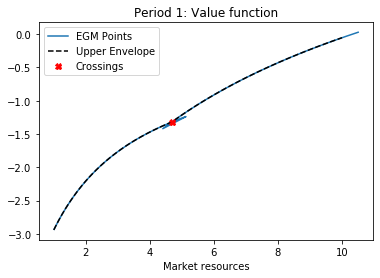

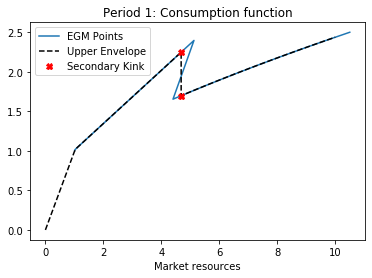

In [18]:
# Calculate envelope
vTGrid1 = vTransf(vGrid1) # The function operates with *transformed* value grids

rise, fall = calcSegments(mGrid1, vTGrid1)
mGrid1_up, cGrid1_up, vTGrid1_up, xings = calcMultilineEnvelope(mGrid1, cGrid1,
                                                                vTGrid1, mGrid,
                                                                findXings = True)
# Create functions
c1_up  = LinearInterp(mGrid1_up, cGrid1_up)
v1T_up = LinearInterp(mGrid1_up, vTGrid1_up)
v1_up  = lambda x: vUntransf(v1T_up(x))

# Extract crossing points
xing_m = np.array(xings)
xing_v = v1_up(xings)

# Show that there is a non-monothonicity and that the upper envelope fixes it
plt.plot(mGrid1,vGrid1, label = 'EGM Points')
plt.plot(mGridPlots, v1_up(mGridPlots), 'k--', label = 'Upper Envelope')
plt.plot(xing_m, xing_v, 'rX', label = 'Crossings')
plt.plot()
plt.title('Period 1: Value function')
plt.xlabel('Market resources')
plt.legend()
plt.show()

# For the consumption function, we want to highlight the sharp discontinuity,
# so we'll add points to the grid that make it evident.
add_m_points = np.concatenate([xing_m, np.nextafter(xing_m, np.inf)])
mGridPlotsC_disc = np.concatenate([mGridPlotsC, add_m_points])
mGridPlotsC_disc.sort()

# Plot consumption
plt.plot(mGrid1,cGrid1, label = 'EGM Points')
plt.plot(mGridPlotsC_disc,c1_up(mGridPlotsC_disc),'k--', label = 'Upper Envelope')
plt.plot(add_m_points, c1_up(add_m_points),'rX', label = 'Secondary Kink')
plt.title('Period 1: Consumption function')
plt.xlabel('Market resources')
plt.legend()
plt.show()

# References
[1] Iskhakov, F. , Jørgensen, T. H., Rust, J. and Schjerning, B. (2017), The endogenous grid method for discrete‐continuous dynamic choice models with (or without) taste shocks. Quantitative Economics, 8: 317-365. doi:10.3982/QE643

[2] Carroll, C. D. (2006). The method of endogenous gridpoints for solving dynamic stochastic optimization problems. Economics letters, 91(3), 312-320.

